In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests

In [2]:
sales_df = pd.read_csv('sales_data_sample.csv', encoding='cp1250')

In [3]:
sales_df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [4]:
np.unique(sales_df['COUNTRY'])

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland',
       'France', 'Germany', 'Ireland', 'Italy', 'Japan', 'Norway',
       'Philippines', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'UK',
       'USA'], dtype=object)

In [6]:
country_currency_dict = {
    'Australia': "AUD",
    'Austria': "EUR",
    'Belgium': "EUR",
    'Canada': "CAD", 
    'Denmark': "EUR", 
    'Finland': "EUR",
    'France': "EUR", 
    'Germany': "EUR", 
    'Ireland': "EUR", 
    'Italy': "EUR", 
    'Japan': "JPY", 
    'Norway': "NOK",
    'Philippines': "PHP",
    'Singapore': "SGD", 
    'Spain': "EUR", 
    'Sweden': "SEK", 
    'Switzerland': "CHF", 
    'UK': "GBP",
    'USA': "DOL"
}

In [7]:
sales_df['CURRENCY'] = sales_df['COUNTRY'].map(country_currency_dict)

In [8]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


# Wymiary (numery kolumn)
+ Czas (5,7,8,9)
+ Geografia (hierarchia) (15,16,17,18,19,20,21,25)
+ klienci (13,14,15,16,22,23)
+ produkt (10,11,12)

# Fakty
2 tabele faktowe? Czy zmergowane ceny walut do zamówienia
+ Zamówienie (1,2,3,4,6,24)
+ Cena waluty (każdego dnia?/ miesiąca?)


# Częstotliwość odświeżania

In [9]:
sales_df['ORDERDATE'] = sales_df['ORDERDATE'].astype("datetime64")
min(sales_df['ORDERDATE']), max(sales_df['ORDERDATE'])

(Timestamp('2003-01-06 00:00:00'), Timestamp('2005-05-31 00:00:00'))

<AxesSubplot:xlabel='ORDERDATE,ORDERDATE'>

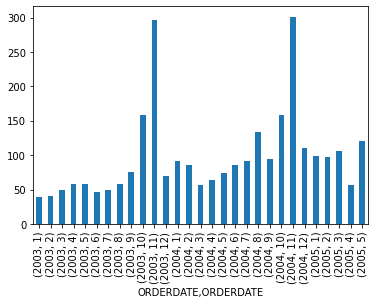

In [10]:
sales_df['ORDERDATE'].groupby([sales_df["ORDERDATE"].dt.year, sales_df["ORDERDATE"].dt.month]).count().plot(kind="bar")

Miesięczna częstotliwość odświeżania wydaje się być ok.

# Join do danych z API NBP

In [11]:
API_URL = "http://api.nbp.pl/api/exchangerates/rates/{table}/{code}/{date}/?format=json"
print(API_URL.format(table='a', code='EUR', date='2003-06-05'))
r = requests.get(API_URL.format(table='a', code='EUR', date='2003-01-06'))
r.json()

http://api.nbp.pl/api/exchangerates/rates/a/EUR/2003-06-05/?format=json


{'table': 'A',
 'country': 'UGW',
 'symbol': '978',
 'code': 'EUR',
 'rates': [{'no': '3/A/NBP/2003',
   'effectiveDate': '2003-01-06',
   'mid': 3.9987}]}

In [12]:
sales_df.iloc[123]['ORDERDATE'].isoformat()[:10]

'2004-11-01'

In [13]:
def get_currency_rate(record):
    date = record['ORDERDATE']
    currency = record['CURRENCY']
    r = requests.get(API_URL.format(table='a', code=currency, date=date.isoformat()[:10]))
    if r.status_code == 200:
        return r.json()
    if r.status_code == 404:
        raise Exception("Got code {status}".format(status=r.status_code))

In [14]:
get_currency_rate(sales_df.iloc[123])

Exception: Got code 404

In [15]:
not_matched = 0
for idx, record in sales_df.sample(n=100).iterrows():
    try:
        get_currency_rate(record)
    except Exception:
        not_matched += 1

In [16]:
not_matched

48

Około połowa nie zapytań daje error. Może funkcja pobierająca ma jakiś błąd, albo są daty dla których nie ma notowań